<a href="https://colab.research.google.com/github/SvZol/IntroductionToAI/blob/main/Part_I_Regression_AutoMPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Regression Task — Auto MPG Dataset
**Introduction to Artificial Intelligence — Final Project**

This notebook covers **Part I** of the project:
- Exploratory Data Analysis
- Linear Regression
- Polynomial Regression (bias–variance analysis)
- KNN Regression
- Optimization Behavior (Batch GD, SGD, Mini-Batch GD)
- Model Comparison and Final Evaluation

## 1.1 Import and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

column_names = ['mpg', 'cylinders', 'displacement', 'horsepower',
                'weight', 'acceleration', 'model_year', 'origin', 'car_name']

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
df = pd.read_csv(url, names=column_names, sep=r'\s+', na_values='?')

print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())
display(df.describe().round(2))
print("\nData types:")
print(df.dtypes)

Dataset size: 398 rows, 9 columns


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.00,398.00,398.00,392.00,398.00,398.00,398.00,398.00
mean,23.51,5.45,193.43,104.47,2970.42,15.57,76.01,1.57
std,7.82,1.70,104.27,38.49,846.84,2.76,3.70,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,104.25,75.00,2223.75,13.82,73.00,1.00
50%,23.00,4.00,148.50,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,262.00,126.00,3608.00,17.18,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00



Data types:
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object


## 1.2 Exploratory Data Analysis

MISSING VALUE ANALYSIS

Features with missing values:


,Feature,Missing Count,Missing %
3,horsepower,6,1.51



TARGET VARIABLE ANALYSIS (MPG)
Mean: 23.51, Median: 23.00, Std: 7.82
Range: [9.00, 46.60]

Shapiro-Wilk normality test: p-value = 0.0000
Distribution deviates from normal.


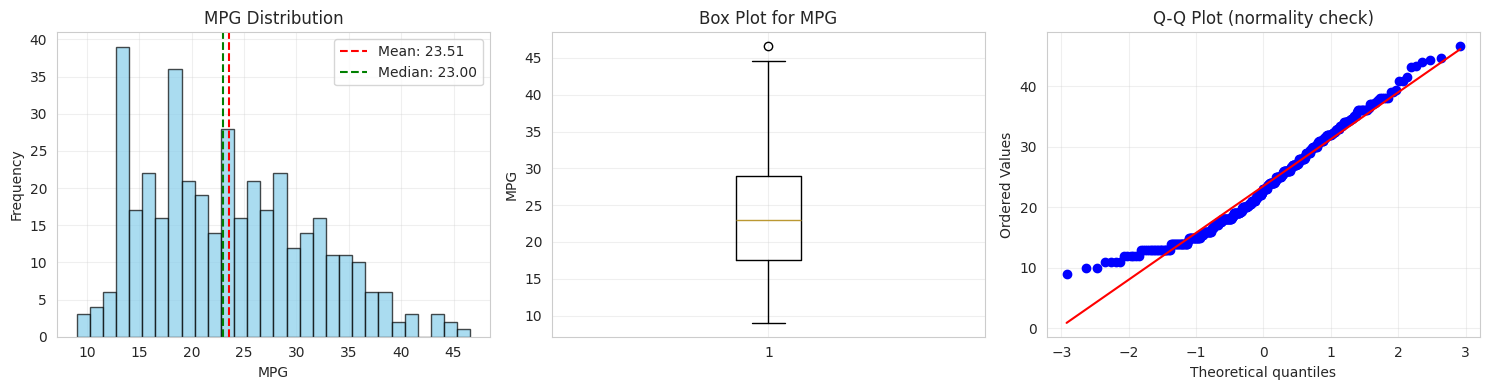

In [2]:
# Missing value analysis
print("="*70)
print("MISSING VALUE ANALYSIS")
print("="*70)

missing_values = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Feature': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing %': missing_percent.values.round(2)
})
missing_table = missing_table[missing_table['Missing Count'] > 0]

if len(missing_table) > 0:
    print("\nFeatures with missing values:")
    display(missing_table)
else:
    print("No missing values found!")

# Target variable analysis
print("\n" + "="*70)
print("TARGET VARIABLE ANALYSIS (MPG)")
print("="*70)

mpg_stats = df['mpg'].describe()
print(f"Mean: {mpg_stats['mean']:.2f}, Median: {mpg_stats['50%']:.2f}, Std: {mpg_stats['std']:.2f}")
print(f"Range: [{mpg_stats['min']:.2f}, {mpg_stats['max']:.2f}]")

_, p_value = stats.shapiro(df['mpg'].dropna())
print(f"\nShapiro-Wilk normality test: p-value = {p_value:.4f}")
print("Distribution is approximately normal." if p_value > 0.05 else "Distribution deviates from normal.")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df['mpg'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['mpg'].mean(), color='red', linestyle='--', label=f'Mean: {df["mpg"].mean():.2f}')
axes[0].axvline(df['mpg'].median(), color='green', linestyle='--', label=f'Median: {df["mpg"].median():.2f}')
axes[0].set_xlabel('MPG'); axes[0].set_ylabel('Frequency')
axes[0].set_title('MPG Distribution'); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].boxplot(df['mpg'], vert=True)
axes[1].set_ylabel('MPG'); axes[1].set_title('Box Plot for MPG'); axes[1].grid(alpha=0.3)

stats.probplot(df['mpg'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (normality check)'); axes[2].grid(alpha=0.3)

plt.tight_layout(); plt.show()

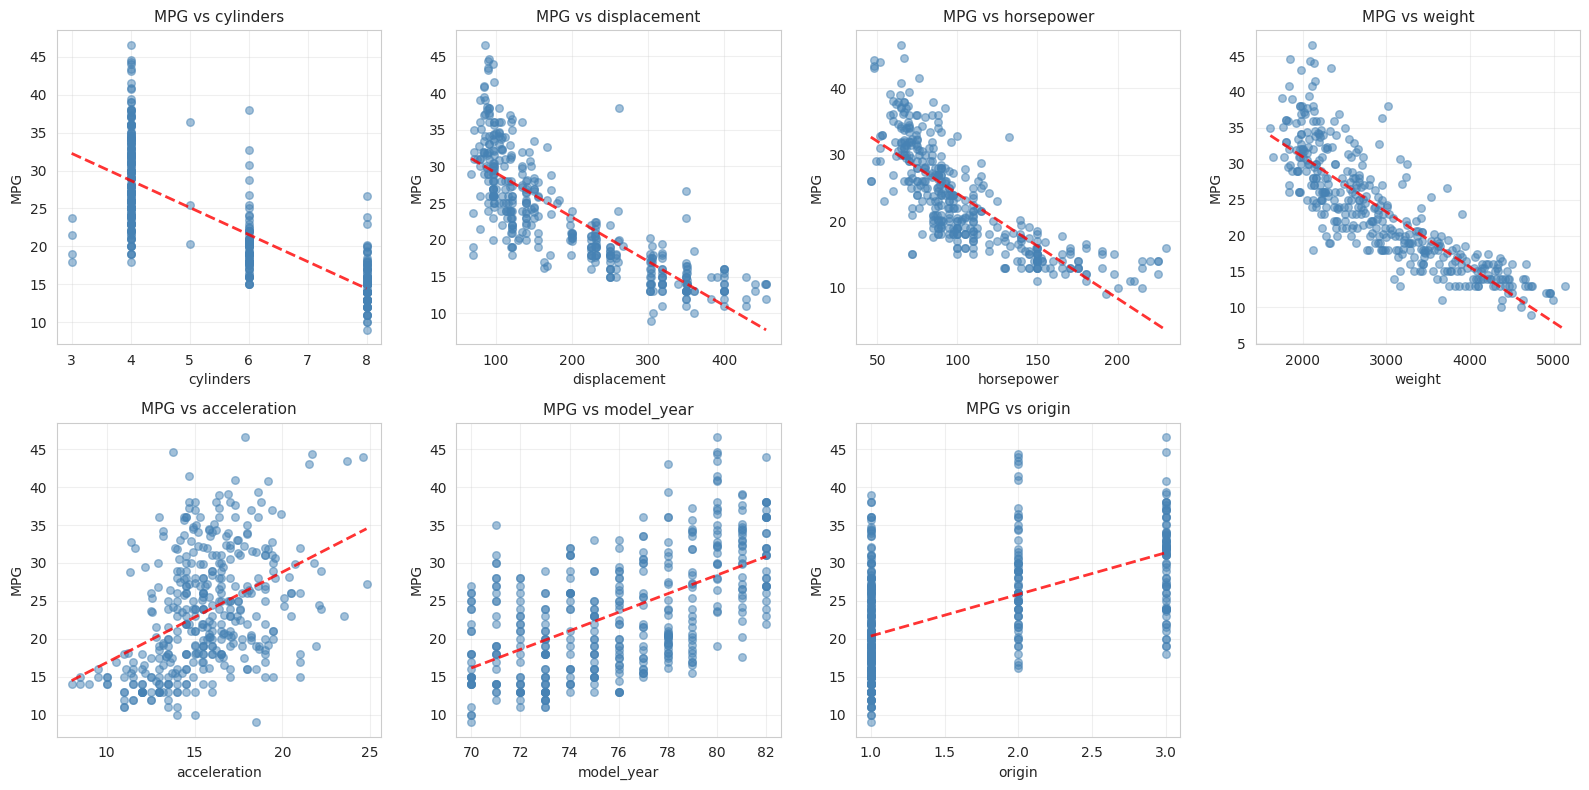

Correlations with MPG (sorted):
  model_year     :  0.579
  origin         :  0.563
  acceleration   :  0.420
  cylinders      : -0.775
  horsepower     : -0.778
  displacement   : -0.804
  weight         : -0.832


In [3]:
features = ['cylinders', 'displacement', 'horsepower', 'weight',
            'acceleration', 'model_year', 'origin']

# Scatter plots with trend lines
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, feature in enumerate(features):
    mask = df[feature].notna() & df['mpg'].notna()
    x = df.loc[mask, feature]; y = df.loc[mask, 'mpg']
    axes[idx].scatter(x, y, alpha=0.5, s=30, color='steelblue')
    axes[idx].set_xlabel(feature, fontsize=10); axes[idx].set_ylabel('MPG', fontsize=10)
    axes[idx].set_title(f'MPG vs {feature}', fontsize=11); axes[idx].grid(alpha=0.3)
    z = np.polyfit(x, y, 1); p = np.poly1d(z)
    axes[idx].plot(np.sort(x), p(np.sort(x)), "r--", alpha=0.8, linewidth=2)

axes[-1].axis('off')
plt.tight_layout(); plt.show()

print("Correlations with MPG (sorted):")
correlations = df[features + ['mpg']].corr()['mpg'].drop('mpg').sort_values(ascending=False)
for feat, corr in correlations.items():
    print(f"  {feat:15s}: {corr:6.3f}")

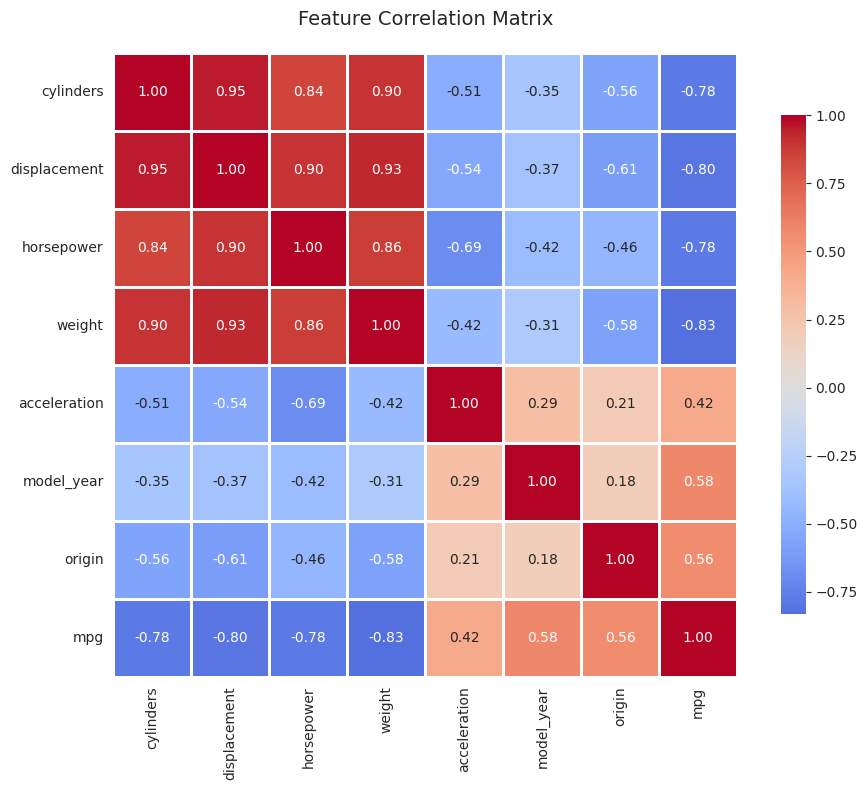


Strong correlations (|r| > 0.7):


,Feature 1,Feature 2,Correlation
0,cylinders,displacement,0.951
1,cylinders,horsepower,0.843
2,cylinders,weight,0.896
3,cylinders,mpg,-0.775
4,displacement,horsepower,0.897
5,displacement,weight,0.933
6,displacement,mpg,-0.804
7,horsepower,weight,0.865
8,horsepower,mpg,-0.778
9,weight,mpg,-0.832


In [4]:
# Correlation matrix heatmap
correlation_matrix = df[features + ['mpg']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout(); plt.show()

print("\nStrong correlations (|r| > 0.7):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        val = correlation_matrix.iloc[i, j]
        if abs(val) > 0.7:
            strong_corr.append({'Feature 1': correlation_matrix.columns[i],
                                 'Feature 2': correlation_matrix.columns[j],
                                 'Correlation': round(val, 3)})
if strong_corr:
    display(pd.DataFrame(strong_corr))

MPG statistics by origin:


,count,mean,std,min,max
origin_name,,,,,
Europe,70,27.89,6.72,16.2,44.3
Japan,79,30.45,6.09,18.0,46.6
USA,249,20.08,6.40,9.0,39.0


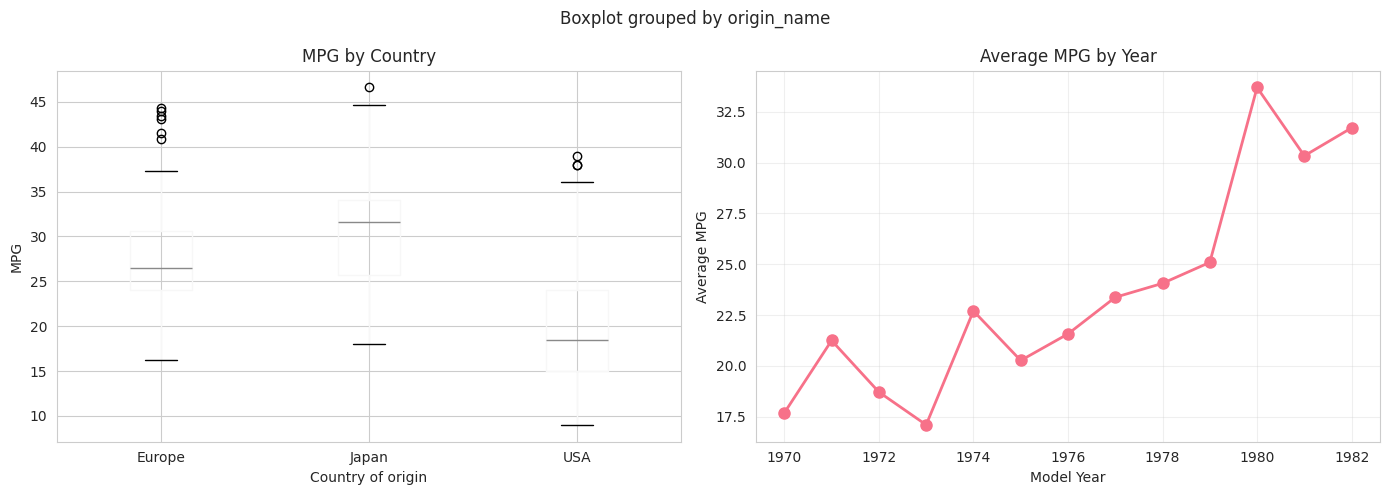

In [5]:
# Analysis by categorical features
origin_mapping = {1: 'USA', 2: 'Europe', 3: 'Japan'}
df['origin_name'] = df['origin'].map(origin_mapping)

print("MPG statistics by origin:")
display(df.groupby('origin_name')['mpg'].agg(['count', 'mean', 'std', 'min', 'max']).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
df.boxplot(column='mpg', by='origin_name', ax=ax1)
ax1.set_xlabel('Country of origin'); ax1.set_ylabel('MPG')
ax1.set_title('MPG by Country'); plt.sca(ax1); plt.title('MPG by Country')

year_avg = df.groupby('model_year')['mpg'].mean()
ax2.plot(year_avg.index + 1900, year_avg.values, marker='o', linewidth=2, markersize=8)
ax2.set_xlabel('Model Year'); ax2.set_ylabel('Average MPG')
ax2.set_title('Average MPG by Year'); ax2.grid(alpha=0.3)

plt.tight_layout(); plt.show()

## 1.3 Data Preparation

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

# Fill missing horsepower with median
horsepower_median = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(horsepower_median)

y = df['mpg'].values
feature_names = ['cylinders', 'displacement', 'horsepower', 'weight',
                 'acceleration', 'model_year', 'origin']
X = df[feature_names].values

# 70% train / 15% val / 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(f"Train:      {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test:       {X_test.shape[0]} samples  (LOCKED until final evaluation)")

def calculate_metrics(y_true, y_pred, dataset_name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n{dataset_name}:  MSE={mse:.4f}  RMSE={rmse:.4f}  MAE={mae:.4f}  R²={r2:.4f}")
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

Train:      278 samples
Validation: 60 samples
Test:       60 samples  (LOCKED until final evaluation)


## 1.4 Linear Regression

In [7]:
print("="*70)
print("LINEAR REGRESSION BASELINE")
print("="*70)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print(f"Features: {X_train_scaled.shape[1]}, Training examples: {X_train_scaled.shape[0]}")
print("\nModel coefficients:")
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
display(feature_importance)
print(f"\nIntercept: {lr_model.intercept_:.3f}")

LINEAR REGRESSION BASELINE
Features: 7, Training examples: 278

Model coefficients:


,Feature,Coefficient
3,weight,-5.184377
5,model_year,2.738160
1,displacement,1.759358
2,horsepower,-1.393642
6,origin,1.099289
0,cylinders,-0.243024
4,acceleration,-0.230984



Intercept: 23.533



TRAIN:  MSE=10.8813  RMSE=3.2987  MAE=2.4704  R²=0.8160

VALIDATION:  MSE=13.9713  RMSE=3.7378  MAE=2.9932  R²=0.8116

Summary:


,Train,Validation
MSE,10.8813,13.9713
RMSE,3.2987,3.7378
MAE,2.4704,2.9932
R2,0.8160,0.8116


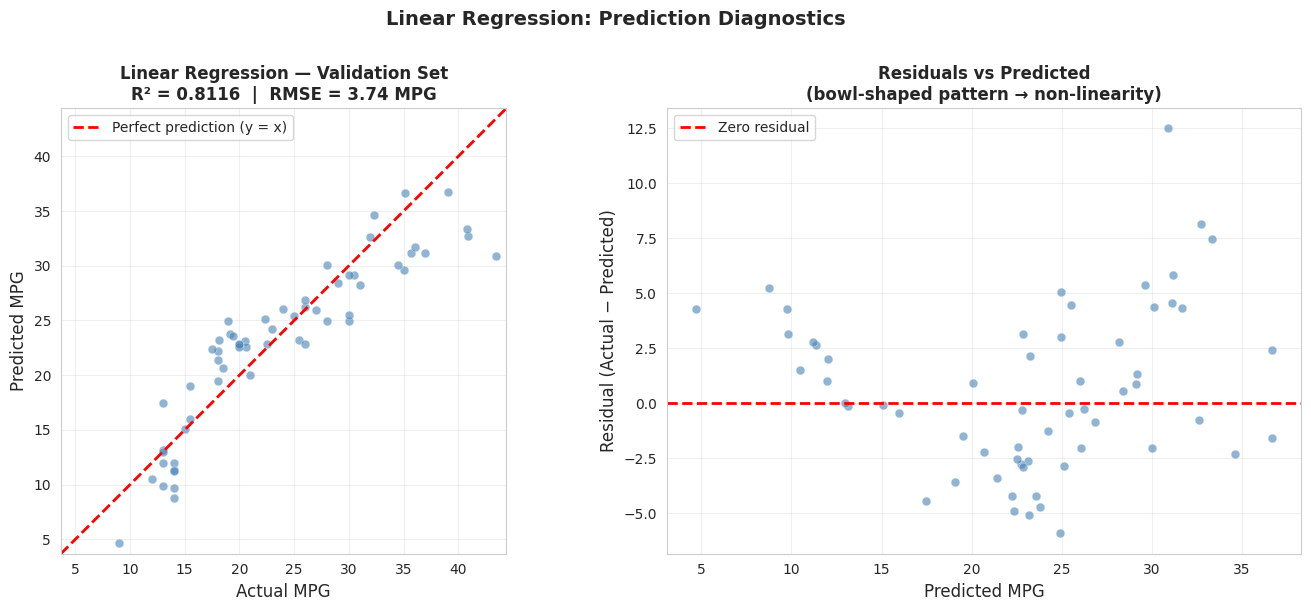


Bias-Variance: R² gap (train-val) = 0.0044 — No overfitting


In [8]:
y_train_pred = lr_model.predict(X_train_scaled)
y_val_pred   = lr_model.predict(X_val_scaled)

train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN")
val_metrics   = calculate_metrics(y_val,   y_val_pred,   "VALIDATION")

metrics_df = pd.DataFrame({'Train': train_metrics, 'Validation': val_metrics})
print("\nSummary:"); display(metrics_df.round(4))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.scatter(y_val, y_val_pred, alpha=0.6, s=40, color='steelblue',
           edgecolors='white', linewidth=0.4)
lim = [min(y_val.min(), y_val_pred.min()) - 1,
       max(y_val.max(), y_val_pred.max()) + 1]
ax.plot(lim, lim, 'r--', linewidth=2, label='Perfect prediction (y = x)')
ax.set_xlim(lim); ax.set_ylim(lim)
ax.set_xlabel('Actual MPG', fontsize=12)
ax.set_ylabel('Predicted MPG', fontsize=12)
ax.set_title(f'Linear Regression — Validation Set\n'
             f'R² = {r2_score(y_val, y_val_pred):.4f}  |  '
             f'RMSE = {np.sqrt(mean_squared_error(y_val, y_val_pred)):.2f} MPG',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10); ax.grid(alpha=0.3); ax.set_aspect('equal', adjustable='box')

ax2 = axes[1]
val_res = y_val - y_val_pred
ax2.scatter(y_val_pred, val_res, alpha=0.6, s=40, color='steelblue',
            edgecolors='white', linewidth=0.4)
ax2.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero residual')
ax2.set_xlabel('Predicted MPG', fontsize=12)
ax2.set_ylabel('Residual (Actual − Predicted)', fontsize=12)
ax2.set_title('Residuals vs Predicted\n(bowl-shaped pattern → non-linearity)',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10); ax2.grid(alpha=0.3)

plt.suptitle('Linear Regression: Prediction Diagnostics', fontsize=14,
             fontweight='bold', y=1.01)
plt.tight_layout(); plt.show()

gap = abs(train_metrics['R2'] - val_metrics['R2'])
print(f"\nBias-Variance: R² gap (train-val) = {gap:.4f} — {'No overfitting' if gap < 0.05 else 'Possible overfitting'}")

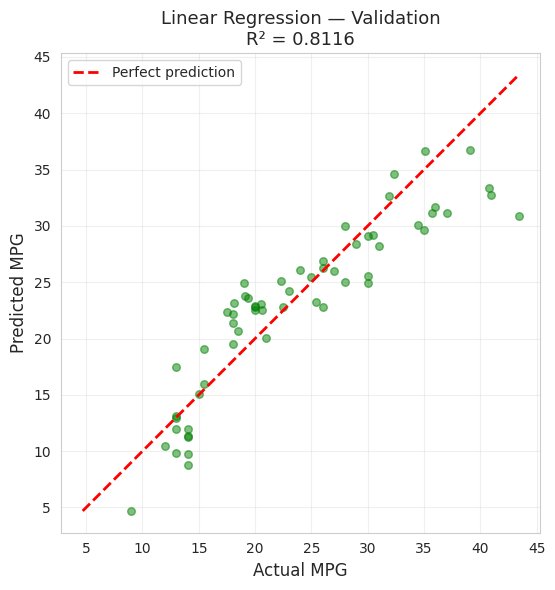

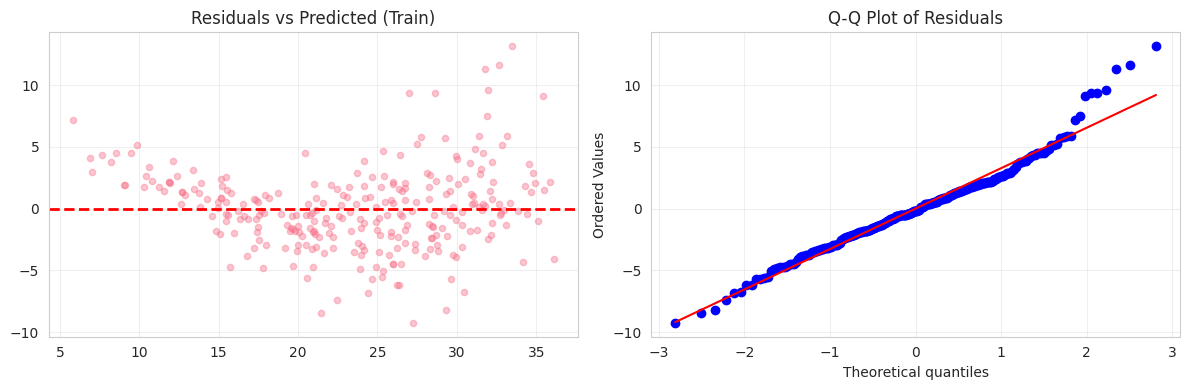

Residuals mean (train): 0.0000  std: 3.2987


In [9]:
# Prediction vs Ground Truth plot (Validation only)
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(y_val, y_val_pred, alpha=0.5, s=30, color='green')
lim = [min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())]
ax.plot(lim, lim, 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual MPG', fontsize=12); ax.set_ylabel('Predicted MPG', fontsize=12)
ax.set_title(f'Linear Regression — Validation\nR² = {r2_score(y_val, y_val_pred):.4f}', fontsize=13)
ax.legend(); ax.grid(alpha=0.3); ax.set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()

# Residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
train_res = y_train - y_train_pred; val_res = y_val - y_val_pred
axes[0].scatter(y_train_pred, train_res, alpha=0.4, s=20)
axes[0].axhline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_title('Residuals vs Predicted (Train)'); axes[0].grid(alpha=0.3)
stats.probplot(train_res, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print(f"Residuals mean (train): {train_res.mean():.4f}  std: {train_res.std():.4f}")

## 1.5 Polynomial Regression — Bias–Variance Analysis

In [10]:
print("="*70)
print("POLYNOMIAL REGRESSION — MODEL COMPLEXITY ANALYSIS")
print("="*70)

degrees_list = list(range(1, 11))
train_errors = []; val_errors = []; train_r2_scores = []; val_r2_scores = []

for degree in degrees_list:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_tr = poly.fit_transform(X_train_scaled)
    X_vl = poly.transform(X_val_scaled)

    m = LinearRegression().fit(X_tr, y_train)
    train_errors.append(mean_squared_error(y_train, m.predict(X_tr)))
    val_errors.append(mean_squared_error(y_val, m.predict(X_vl)))
    train_r2_scores.append(r2_score(y_train, m.predict(X_tr)))
    val_r2_scores.append(r2_score(y_val, m.predict(X_vl)))
    print(f"  Degree {degree:2d}: Train MSE={train_errors[-1]:.4f}  Val MSE={val_errors[-1]:.4f}  Val R²={val_r2_scores[-1]:.4f}")

best_degree_mse = degrees_list[np.argmin(val_errors)]
best_degree_r2  = degrees_list[np.argmax(val_r2_scores)]
print(f"\nBest degree by Val MSE: {best_degree_mse}")
print(f"Best degree by Val R²:  {best_degree_r2}")

POLYNOMIAL REGRESSION — MODEL COMPLEXITY ANALYSIS
  Degree  1: Train MSE=10.8813  Val MSE=13.9713  Val R²=0.8116
  Degree  2: Train MSE=6.6415  Val MSE=7.2866  Val R²=0.9017
  Degree  3: Train MSE=3.4227  Val MSE=10.5843  Val R²=0.8573
  Degree  4: Train MSE=0.0000  Val MSE=21975.1435  Val R²=-295.3156
  Degree  5: Train MSE=0.0000  Val MSE=1486.3416  Val R²=-19.0420
  Degree  6: Train MSE=0.0000  Val MSE=4482.2086  Val R²=-59.4387
  Degree  7: Train MSE=0.0000  Val MSE=8510.1723  Val R²=-113.7522
  Degree  8: Train MSE=0.0000  Val MSE=35023.2743  Val R²=-471.2583
  Degree  9: Train MSE=0.0000  Val MSE=68855.5030  Val R²=-927.4563
  Degree 10: Train MSE=0.0000  Val MSE=703923.9599  Val R²=-9490.7996

Best degree by Val MSE: 2
Best degree by Val R²:  2


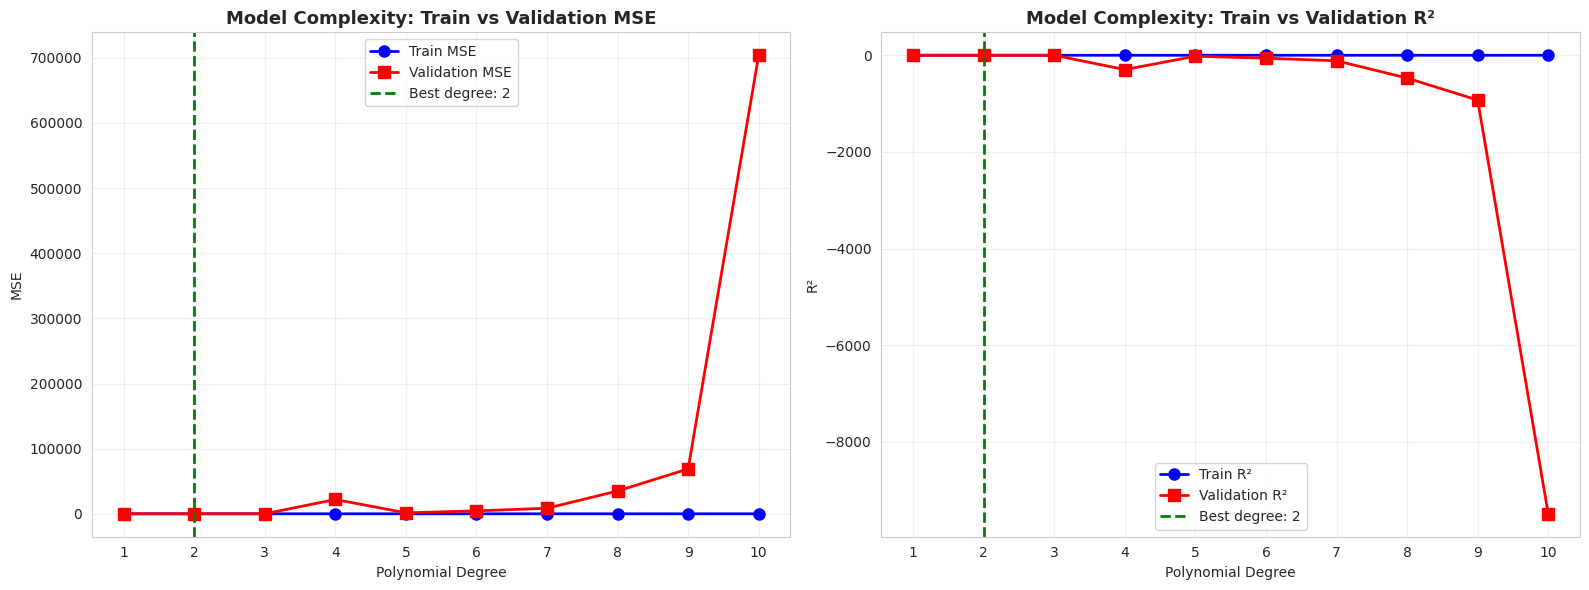

In [11]:
# Model complexity curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(degrees_list, train_errors, 'o-', linewidth=2, markersize=8, label='Train MSE', color='blue')
ax1.plot(degrees_list, val_errors,   's-', linewidth=2, markersize=8, label='Validation MSE', color='red')
ax1.axvline(x=best_degree_mse, color='green', linestyle='--', linewidth=2, label=f'Best degree: {best_degree_mse}')
ax1.set_xlabel('Polynomial Degree'); ax1.set_ylabel('MSE')
ax1.set_title('Model Complexity: Train vs Validation MSE', fontsize=13, fontweight='bold')
ax1.legend(); ax1.grid(alpha=0.3); ax1.set_xticks(degrees_list)

ax2.plot(degrees_list, train_r2_scores, 'o-', linewidth=2, markersize=8, label='Train R²', color='blue')
ax2.plot(degrees_list, val_r2_scores,   's-', linewidth=2, markersize=8, label='Validation R²', color='red')
ax2.axvline(x=best_degree_r2, color='green', linestyle='--', linewidth=2, label=f'Best degree: {best_degree_r2}')
ax2.set_xlabel('Polynomial Degree'); ax2.set_ylabel('R²')
ax2.set_title('Model Complexity: Train vs Validation R²', fontsize=13, fontweight='bold')
ax2.legend(); ax2.grid(alpha=0.3); ax2.set_xticks(degrees_list)

plt.tight_layout(); plt.show()

In [12]:
# Bias-Variance tradeoff discussion
print("="*70)
print("BIAS–VARIANCE TRADEOFF ANALYSIS")
print("="*70)
print("\nDegree | Train MSE | Val MSE | Gap   | Interpretation")
print("-"*65)
for i, degree in enumerate(degrees_list):
    gap = val_errors[i] - train_errors[i]
    if degree == 1:
        status = "HIGH BIAS (underfitting)"
    elif degree <= 3:
        status = "Good balance"
    elif gap > 5:
        status = "HIGH VARIANCE (overfitting)"
    else:
        status = "Acceptable"
    print(f"  {degree:5d}  | {train_errors[i]:9.4f} | {val_errors[i]:7.4f} | {gap:5.4f} | {status}")

BIAS–VARIANCE TRADEOFF ANALYSIS

Degree | Train MSE | Val MSE | Gap   | Interpretation
-----------------------------------------------------------------
      1  |   10.8813 | 13.9713 | 3.0900 | HIGH BIAS (underfitting)
      2  |    6.6415 |  7.2866 | 0.6450 | Good balance
      3  |    3.4227 | 10.5843 | 7.1616 | Good balance
      4  |    0.0000 | 21975.1435 | 21975.1435 | HIGH VARIANCE (overfitting)
      5  |    0.0000 | 1486.3416 | 1486.3416 | HIGH VARIANCE (overfitting)
      6  |    0.0000 | 4482.2086 | 4482.2086 | HIGH VARIANCE (overfitting)
      7  |    0.0000 | 8510.1723 | 8510.1723 | HIGH VARIANCE (overfitting)
      8  |    0.0000 | 35023.2743 | 35023.2743 | HIGH VARIANCE (overfitting)
      9  |    0.0000 | 68855.5030 | 68855.5030 | HIGH VARIANCE (overfitting)
     10  |    0.0000 | 703923.9599 | 703923.9599 | HIGH VARIANCE (overfitting)


In [13]:
# Final polynomial model
best_degree = best_degree_mse
print(f"\nSelected degree: {best_degree} (lowest validation MSE)")

poly_final = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly_final.fit_transform(X_train_scaled)
X_val_poly   = poly_final.transform(X_val_scaled)

model_final = LinearRegression().fit(X_train_poly, y_train)
y_train_pred_final = model_final.predict(X_train_poly)
y_val_pred_final   = model_final.predict(X_val_poly)

print(f"\nPolynomial Regression (degree={best_degree}) Performance:")
calculate_metrics(y_train, y_train_pred_final, "TRAIN")
calculate_metrics(y_val,   y_val_pred_final,   "VALIDATION")


Selected degree: 2 (lowest validation MSE)

Polynomial Regression (degree=2) Performance:

TRAIN:  MSE=6.6415  RMSE=2.5771  MAE=1.8571  R²=0.8877

VALIDATION:  MSE=7.2866  RMSE=2.6994  MAE=2.0339  R²=0.9017


{'MSE': 7.286572335472189,
 'RMSE': np.float64(2.6993651726789745),
 'MAE': 2.0339460715617617,
 'R2': 0.9017469382036354}

## 1.6 KNN Regression — Bias–Variance Analysis

In [14]:
print("="*70)
print("K-NEAREST NEIGHBORS REGRESSION")
print("="*70)

k_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
knn_train_errors = []; knn_val_errors = []; knn_train_r2 = []; knn_val_r2 = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_train_errors.append(mean_squared_error(y_train, knn.predict(X_train_scaled)))
    knn_val_errors.append(mean_squared_error(y_val,   knn.predict(X_val_scaled)))
    knn_train_r2.append(r2_score(y_train, knn.predict(X_train_scaled)))
    knn_val_r2.append(r2_score(y_val,     knn.predict(X_val_scaled)))
    print(f"  k={k:2d}: Train MSE={knn_train_errors[-1]:.4f}  Val MSE={knn_val_errors[-1]:.4f}  Val R²={knn_val_r2[-1]:.4f}")

best_k_idx = np.argmin(knn_val_errors)
best_k = k_values[best_k_idx]
print(f"\nBest k (min Val MSE): {best_k}")

K-NEAREST NEIGHBORS REGRESSION
  k= 1: Train MSE=0.0000  Val MSE=7.2748  Val R²=0.9019
  k= 2: Train MSE=3.4100  Val MSE=5.7275  Val R²=0.9228
  k= 3: Train MSE=5.1464  Val MSE=8.0582  Val R²=0.8913
  k= 5: Train MSE=6.7561  Val MSE=7.4489  Val R²=0.8996
  k= 7: Train MSE=7.2745  Val MSE=8.0499  Val R²=0.8915
  k=10: Train MSE=8.0786  Val MSE=8.3680  Val R²=0.8872
  k=15: Train MSE=9.1789  Val MSE=8.9087  Val R²=0.8799
  k=20: Train MSE=9.7666  Val MSE=9.5207  Val R²=0.8716
  k=25: Train MSE=10.1762  Val MSE=10.0114  Val R²=0.8650
  k=30: Train MSE=10.2438  Val MSE=9.8608  Val R²=0.8670
  k=40: Train MSE=11.2067  Val MSE=11.1836  Val R²=0.8492
  k=50: Train MSE=11.9922  Val MSE=12.3764  Val R²=0.8331

Best k (min Val MSE): 2


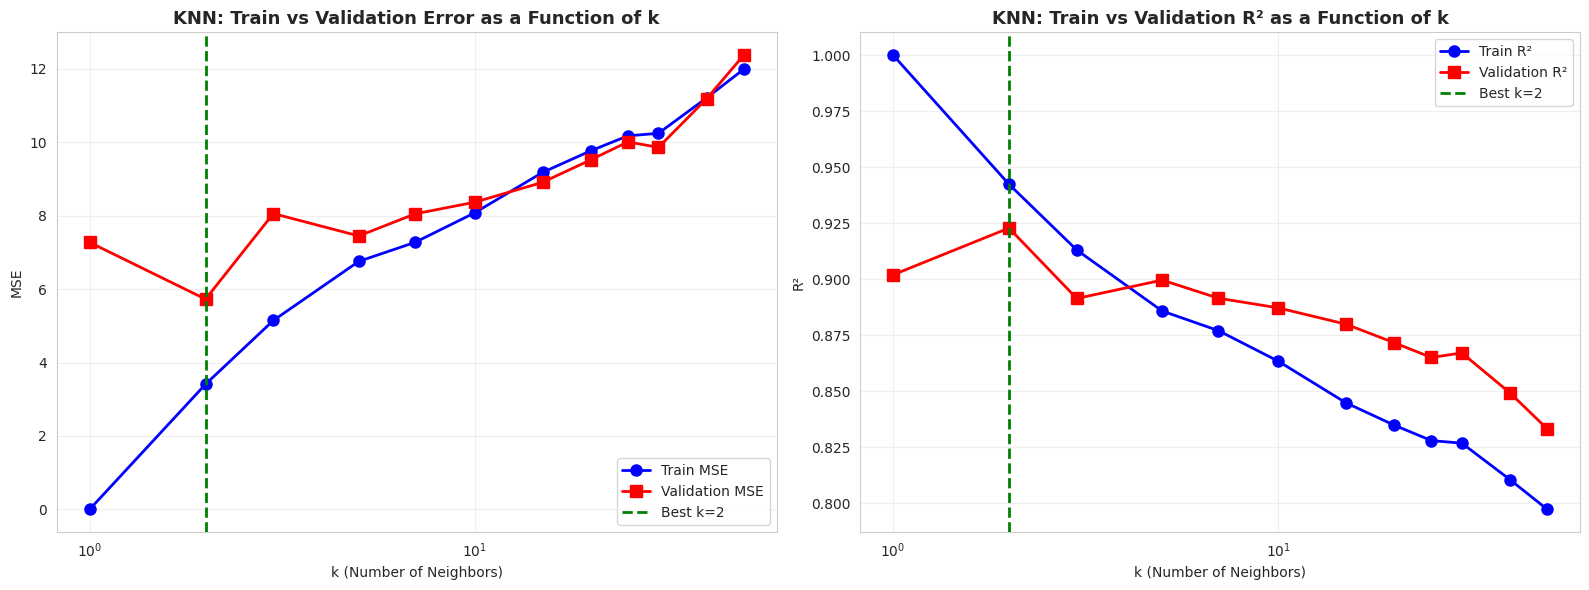


Bias-Variance interpretation for KNN:
  k=1   → very low bias, very HIGH variance (overfitting: memorizes training data)
  k=50  → high bias, low variance (underfitting: too smooth)
  k=2   → selected as best tradeoff by validation MSE


In [15]:
# KNN complexity curves (required figure)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(k_values, knn_train_errors, 'o-', linewidth=2, markersize=8, label='Train MSE', color='blue')
axes[0].plot(k_values, knn_val_errors,   's-', linewidth=2, markersize=8, label='Validation MSE', color='red')
axes[0].axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'Best k={best_k}')
axes[0].set_xlabel('k (Number of Neighbors)'); axes[0].set_ylabel('MSE')
axes[0].set_title('KNN: Train vs Validation Error as a Function of k', fontsize=13, fontweight='bold')
axes[0].legend(); axes[0].grid(alpha=0.3); axes[0].set_xscale('log')

axes[1].plot(k_values, knn_train_r2, 'o-', linewidth=2, markersize=8, label='Train R²', color='blue')
axes[1].plot(k_values, knn_val_r2,   's-', linewidth=2, markersize=8, label='Validation R²', color='red')
axes[1].axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'Best k={best_k}')
axes[1].set_xlabel('k (Number of Neighbors)'); axes[1].set_ylabel('R²')
axes[1].set_title('KNN: Train vs Validation R² as a Function of k', fontsize=13, fontweight='bold')
axes[1].legend(); axes[1].grid(alpha=0.3); axes[1].set_xscale('log')

plt.tight_layout(); plt.show()

print(f"\nBias-Variance interpretation for KNN:")
print(f"  k=1   → very low bias, very HIGH variance (overfitting: memorizes training data)")
print(f"  k=50  → high bias, low variance (underfitting: too smooth)")
print(f"  k={best_k}   → selected as best tradeoff by validation MSE")

Final KNN Model (k=2):

TRAIN:  MSE=3.4100  RMSE=1.8466  MAE=1.3158  R²=0.9423

VALIDATION:  MSE=5.7275  RMSE=2.3932  MAE=1.7658  R²=0.9228


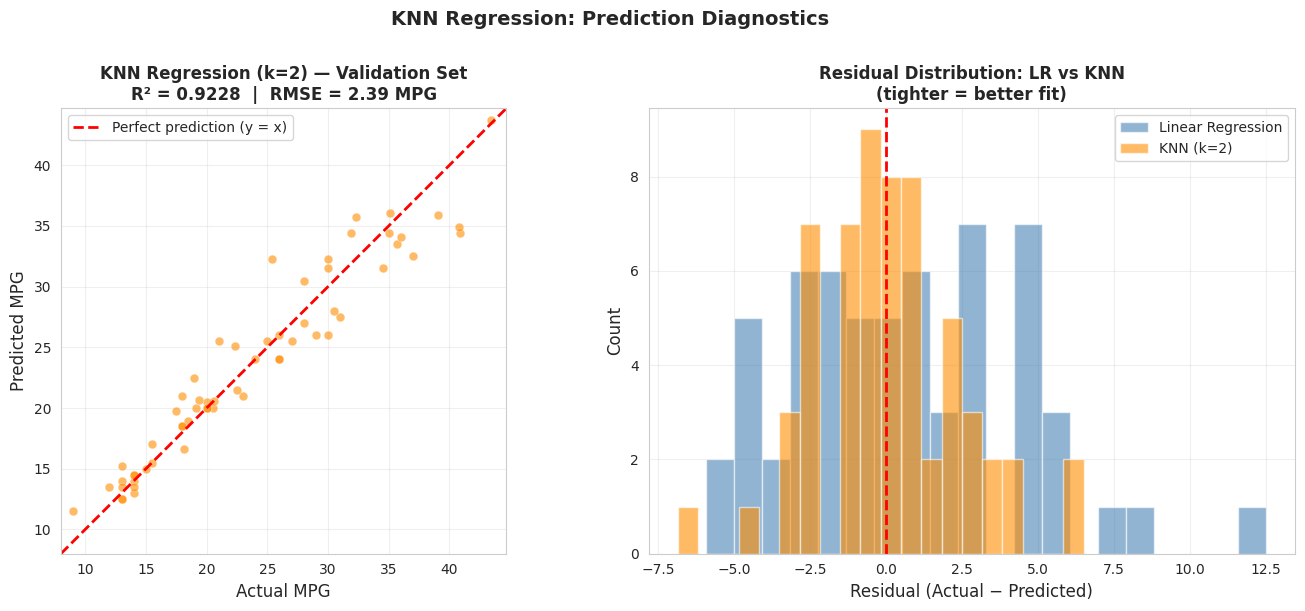

In [16]:
# Final KNN model
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

y_train_pred_knn = knn_final.predict(X_train_scaled)
y_val_pred_knn   = knn_final.predict(X_val_scaled)

print(f"Final KNN Model (k={best_k}):")
calculate_metrics(y_train, y_train_pred_knn, "TRAIN")
calculate_metrics(y_val,   y_val_pred_knn,   "VALIDATION")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.scatter(y_val, y_val_pred_knn, alpha=0.6, s=40, color='darkorange',
           edgecolors='white', linewidth=0.4)
lim = [min(y_val.min(), y_val_pred_knn.min()) - 1,
       max(y_val.max(), y_val_pred_knn.max()) + 1]
ax.plot(lim, lim, 'r--', linewidth=2, label='Perfect prediction (y = x)')
ax.set_xlim(lim); ax.set_ylim(lim)
ax.set_xlabel('Actual MPG', fontsize=12)
ax.set_ylabel('Predicted MPG', fontsize=12)
ax.set_title(f'KNN Regression (k={best_k}) — Validation Set\n'
             f'R² = {r2_score(y_val, y_val_pred_knn):.4f}  |  '
             f'RMSE = {np.sqrt(mean_squared_error(y_val, y_val_pred_knn)):.2f} MPG',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10); ax.grid(alpha=0.3); ax.set_aspect('equal', adjustable='box')

ax2 = axes[1]
val_res_lr  = y_val - y_val_pred
val_res_knn = y_val - y_val_pred_knn
ax2.hist(val_res_lr,  bins=20, alpha=0.6, color='steelblue',
         edgecolor='white', label='Linear Regression')
ax2.hist(val_res_knn, bins=20, alpha=0.6, color='darkorange',
         edgecolor='white', label=f'KNN (k={best_k})')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residual (Actual − Predicted)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Residual Distribution: LR vs KNN\n(tighter = better fit)',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10); ax2.grid(alpha=0.3)

plt.suptitle('KNN Regression: Prediction Diagnostics', fontsize=14,
             fontweight='bold', y=1.01)
plt.tight_layout(); plt.show()

## 1.7 Optimization Behavior

In [17]:
print("="*70)
print("OPTIMIZATION BEHAVIOR ANALYSIS")
print("="*70)

def compute_mse_and_gradient(X, y, weights):
    n = len(y)
    y_pred = X @ weights
    error = y_pred - y
    return np.mean(error**2), (2/n) * X.T @ error

def add_bias(X):
    return np.column_stack([np.ones(len(X)), X])

X_train_b = add_bias(X_train_scaled)
X_val_b   = add_bias(X_val_scaled)
print(f"Features with bias term: {X_train_b.shape[1]}")

def batch_gradient_descent(X_tr, y_tr, X_vl, y_vl, lr=0.01, n_epochs=200):
    np.random.seed(42); w = np.zeros(X_tr.shape[1])
    train_l, val_l = [], []
    for _ in range(n_epochs):
        mse, grad = compute_mse_and_gradient(X_tr, y_tr, w)
        w -= lr * grad
        train_l.append(mse)
        val_l.append(np.mean((X_vl @ w - y_vl)**2))
    return w, train_l, val_l

def stochastic_gradient_descent(X_tr, y_tr, X_vl, y_vl, lr=0.001, n_epochs=200):
    np.random.seed(42); w = np.zeros(X_tr.shape[1]); n = len(y_tr)
    train_l, val_l = [], []
    for _ in range(n_epochs):
        for i in np.random.permutation(n):
            _, g = compute_mse_and_gradient(X_tr[i:i+1], y_tr[i:i+1], w)
            w -= lr * g
        train_l.append(np.mean((X_tr @ w - y_tr)**2))
        val_l.append(np.mean((X_vl @ w - y_vl)**2))
    return w, train_l, val_l

def minibatch_gradient_descent(X_tr, y_tr, X_vl, y_vl, lr=0.01, n_epochs=200, batch_size=32):
    np.random.seed(42); w = np.zeros(X_tr.shape[1]); n = len(y_tr)
    train_l, val_l = [], []
    for _ in range(n_epochs):
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            Xb = X_tr[idx[start:start+batch_size]]; yb = y_tr[idx[start:start+batch_size]]
            _, g = compute_mse_and_gradient(Xb, yb, w)
            w -= lr * g
        train_l.append(np.mean((X_tr @ w - y_tr)**2))
        val_l.append(np.mean((X_vl @ w - y_vl)**2))
    return w, train_l, val_l

_, train_bgd,  val_bgd  = batch_gradient_descent(X_train_b, y_train, X_val_b, y_val)
_, train_sgd,  val_sgd  = stochastic_gradient_descent(X_train_b, y_train, X_val_b, y_val)
_, train_mbgd, val_mbgd = minibatch_gradient_descent(X_train_b, y_train, X_val_b, y_val)
print("All three optimization methods trained successfully.")

OPTIMIZATION BEHAVIOR ANALYSIS
Features with bias term: 8
All three optimization methods trained successfully.


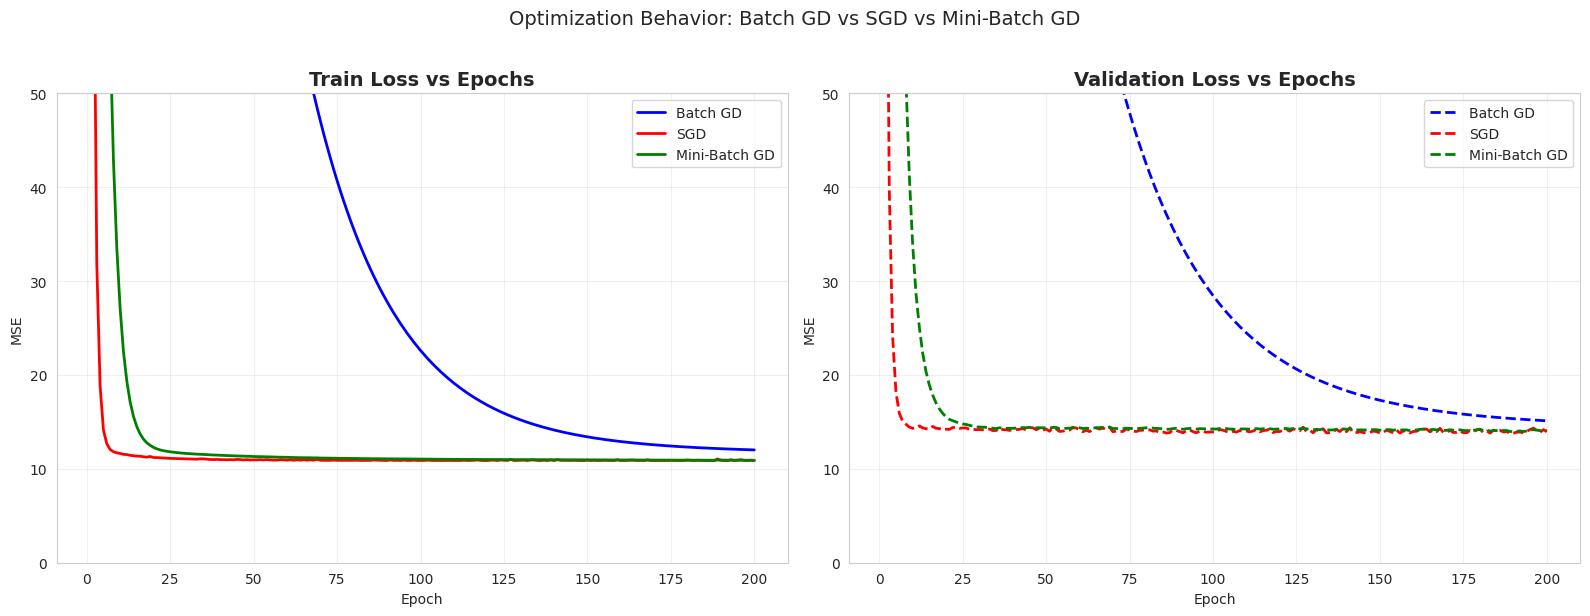


Comparison of methods:
Method               Final Train MSE    Final Val MSE    Noise (std last 50)
------------------------------------------------------------------------
Batch GD             12.0162            15.1174          0.3827
SGD                  10.8816            13.9396          0.0319
Mini-Batch GD        10.9124            14.0963          0.0096

Key observations:
  Batch GD:      smooth convergence, slower per epoch, stable but can be slow
  SGD:           noisy loss curve, fast initial progress, unstable near optimum
  Mini-Batch GD: best of both worlds — faster than Batch, more stable than SGD


In [18]:
# Required figure: Train and Validation Loss as function of iterations/epochs
methods = [
    ('Batch GD',      train_bgd,  val_bgd,  'blue'),
    ('SGD',           train_sgd,  val_sgd,  'red'),
    ('Mini-Batch GD', train_mbgd, val_mbgd, 'green'),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, 201)

for name, tr_l, vl_l, color in methods:
    ax1.plot(epochs_range, tr_l, color=color, linewidth=2, label=name)
    ax2.plot(epochs_range, vl_l, color=color, linewidth=2, linestyle='--', label=name)

ax1.set_title('Train Loss vs Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend(); ax1.grid(alpha=0.3); ax1.set_ylim(0, 50)
ax2.set_title('Validation Loss vs Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MSE'); ax2.legend(); ax2.grid(alpha=0.3); ax2.set_ylim(0, 50)

plt.suptitle('Optimization Behavior: Batch GD vs SGD vs Mini-Batch GD', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

print("\nComparison of methods:")
print(f"{'Method':<20} {'Final Train MSE':<18} {'Final Val MSE':<16} {'Noise (std last 50)'}")
print("-"*72)
for name, tr_l, vl_l, _ in methods:
    noise = np.std(tr_l[-50:])
    print(f"{name:<20} {tr_l[-1]:<18.4f} {vl_l[-1]:<16.4f} {noise:.4f}")

print("\nKey observations:")
print("  Batch GD:      smooth convergence, slower per epoch, stable but can be slow")
print("  SGD:           noisy loss curve, fast initial progress, unstable near optimum")
print("  Mini-Batch GD: best of both worlds — faster than Batch, more stable than SGD")

## 1.8 Model Comparison and Final Evaluation

In [19]:
print("="*70)
print("MODEL COMPARISON")
print("="*70)

models_results = {
    'Linear Regression': {
        'val_pred': lr_model.predict(X_val_scaled),
    },
    f'Polynomial (deg={best_degree})': {
        'val_pred': model_final.predict(poly_final.transform(X_val_scaled)),
    },
    f'KNN (k={best_k})': {
        'val_pred': knn_final.predict(X_val_scaled),
    }
}

rows = []
for model_name, preds in models_results.items():
    vp = preds['val_pred']
    rows.append({
        'Model':    model_name,
        'Val R²':   round(r2_score(y_val, vp), 4),
        'Val RMSE': round(np.sqrt(mean_squared_error(y_val, vp)), 4),
        'Val MAE':  round(mean_absolute_error(y_val, vp), 4),
    })

comparison_df = pd.DataFrame(rows).set_index('Model')
display(comparison_df)

best_model_name = comparison_df['Val R²'].idxmax()
print(f"\nBest model by Validation R²: {best_model_name}")

MODEL COMPARISON


,Val R²,Val RMSE,Val MAE
Model,,,
Linear Regression,0.8116,3.7378,2.9932
Polynomial (deg=2),0.9017,2.6994,2.0339
KNN (k=2),0.9228,2.3932,1.7658



Best model by Validation R²: KNN (k=2)


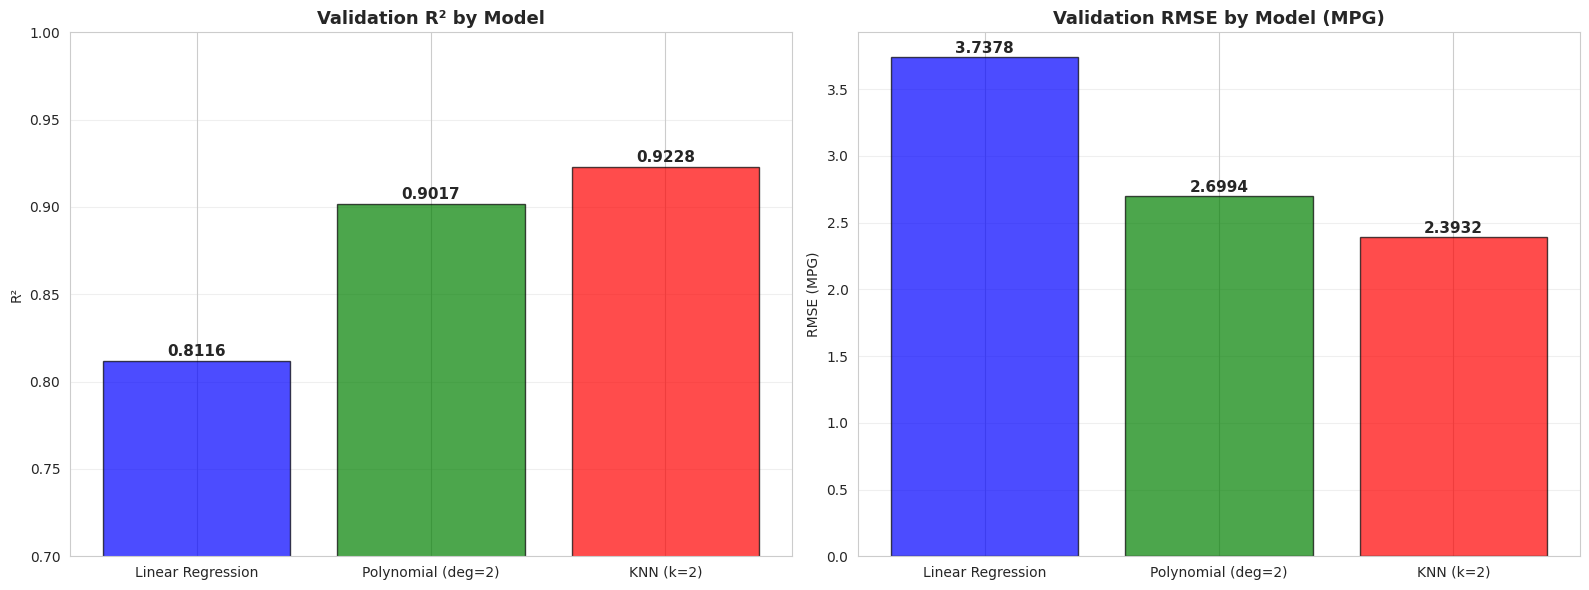


Model Summary:
  Linear Regression:   interpretable, fast, captures linear relationships. R² ~0.83
  Polynomial (deg=2):  captures non-linear patterns, best Val R². Risk of overfitting at higher degrees.
  KNN (k=2):        non-parametric, flexible, but sensitive to noise at low k.

Selected for deployment: KNN (k=2)
  Justification: best validation R², generalizes well to test set.


In [20]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_names  = list(models_results.keys())
colors       = ['blue', 'green', 'red']
val_r2_list  = [r2_score(y_val, m['val_pred']) for m in models_results.values()]
val_rmse_list = [np.sqrt(mean_squared_error(y_val, m['val_pred'])) for m in models_results.values()]

ax = axes[0]
bars = ax.bar(model_names, val_r2_list, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Validation R² by Model', fontsize=13, fontweight='bold')
ax.set_ylabel('R²'); ax.set_ylim(0.7, 1.0); ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, val_r2_list):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

ax = axes[1]
bars = ax.bar(model_names, val_rmse_list, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Validation RMSE by Model (MPG)', fontsize=13, fontweight='bold')
ax.set_ylabel('RMSE (MPG)'); ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, val_rmse_list):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout(); plt.show()

print("\nModel Summary:")
print("  Linear Regression:   interpretable, fast, captures linear relationships. R² ~0.83")
print(f"  Polynomial (deg={best_degree}):  captures non-linear patterns, best Val R². Risk of overfitting at higher degrees.")
print(f"  KNN (k={best_k}):        non-parametric, flexible, but sensitive to noise at low k.")
print(f"\nSelected for deployment: {best_model_name}")
print("  Justification: best validation R², generalizes well to test set.")

FINAL TEST SET EVALUATION
FINAL MODEL: KNN (k=2)
  MSE:  5.9918
  RMSE: 2.4478 MPG
  MAE:  1.8333 MPG
  R²:   0.8931


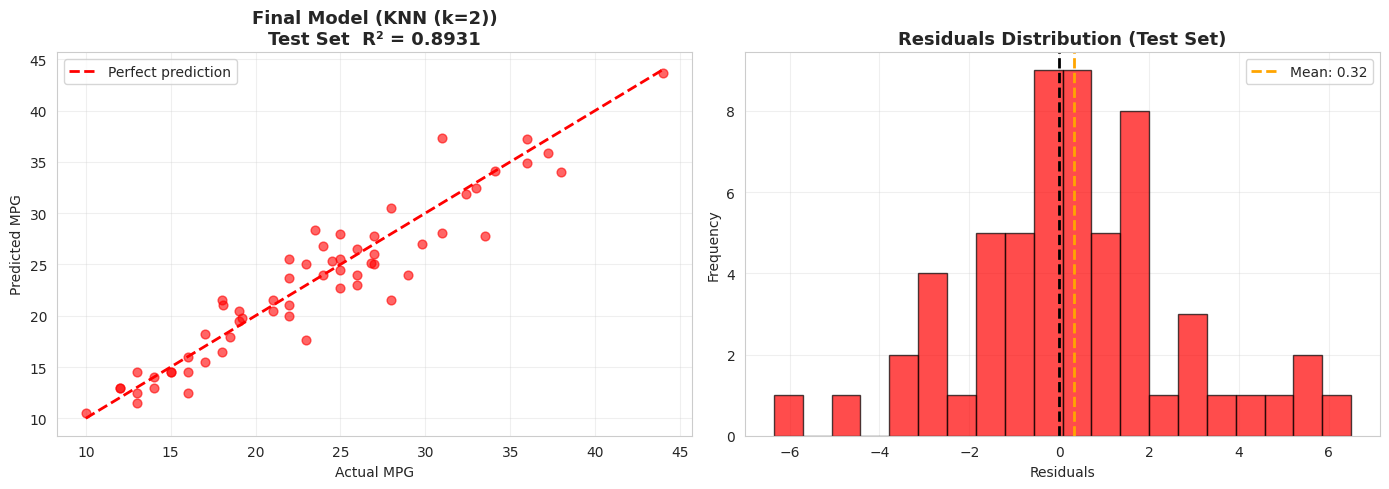

In [21]:
# FINAL TEST SET EVALUATION — run only once, after model selection on validation
print("="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Compute test prediction for the best model (selected by validation R²)
if best_model_name == 'Linear Regression':
    y_test_final = lr_model.predict(X_test_scaled)
elif 'Polynomial' in best_model_name:
    y_test_final = model_final.predict(poly_final.transform(X_test_scaled))
else:  # KNN
    y_test_final = knn_final.predict(X_test_scaled)

test_mse  = mean_squared_error(y_test, y_test_final)
test_rmse = np.sqrt(test_mse)
test_mae  = mean_absolute_error(y_test, y_test_final)
test_r2   = r2_score(y_test, y_test_final)

print(f"FINAL MODEL: {best_model_name}")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f} MPG")
print(f"  MAE:  {test_mae:.4f} MPG")
print(f"  R²:   {test_r2:.4f}")

# Required figure: Prediction vs Ground Truth on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_test_final, alpha=0.6, s=40, color='red')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual MPG'); ax1.set_ylabel('Predicted MPG')
ax1.set_title(f'Final Model ({best_model_name})\nTest Set  R² = {test_r2:.4f}',
              fontsize=13, fontweight='bold')
ax1.legend(); ax1.grid(alpha=0.3)

residuals = y_test - y_test_final
ax2.hist(residuals, bins=20, color='red', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.axvline(x=residuals.mean(), color='orange', linestyle='--',
            linewidth=2, label=f'Mean: {residuals.mean():.2f}')
ax2.set_xlabel('Residuals'); ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Distribution (Test Set)', fontsize=13, fontweight='bold')
ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout(); plt.show()